# Preprocessing data for Metastatic Breast Cancer Data (or Ovarian Cancer Data)

The following notebook is meant to be run through papermill parametrized for data type (res_name) of "MBC" (metastatic breast cancer) or "OVC" (ovarian cancer). It can aslo be run directly. Please download the data from the links below prior to running. The notebook QC the data, and saves it to be used later. The data is already filtered according to the original publication. 

[Original paper data can be found here](https://www.nature.com/articles/s41591-020-0844-1#data-availability)

[Data can be downaloded here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140819) 

### **We recommend downloading "custom", only the following samples:** 

### MBC:	

Nuclei	HTAPP-963-SMP-4741 

Cells	HTAPP-963-SMP-4741 & HTAPP-285-SMP-751

### OVC:	

Nuclei	HTAPP-316-SMP-991 (Resection CST)

Cells	HTAPP-624-SMP-3212 (Resection) & HTAPP-727-SMP-3781 (Ascites)

In [1]:
# import the dependencies
import sys
import sys
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc
import anndata as ad
import gzip
import re
import shutil
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
from pathlib import Path

# Ensure PYTHONPATH includes the parent directory of 'src'
sys.path.insert(1, "../../")
sys.path.insert(1, "../")
sys.path.insert(1, "../../../../../")

from src.helpers import (
    match_cell_types,
    load_MBC_data,
    make_prop_table,
    assign_cell_types,
    load_OVC_data,
)

We'll demostrate with metastatic breast cancer data from: 

In [2]:
res_name = "MBC"

## Reading in the single-cell and single-nucleus data

Single-Cell

In [3]:
if res_name == "MBC":
    sc_adata, sc_metadata = load_MBC_data("single_cell")
elif res_name == "OVC":
    sc_adata, sc_metadata = load_OVC_data("single_cell")
sc_metadata

Skipping extraction: Data already exists in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/OVC/.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,emptydrop,doublet,cell
0,HTAPP-624-SMP-3212_fresh-AAACCCAAGATCCAAA,Epithelial cell,18194,15513,3309,0.085219,False,False,AAACCCAAGATCCAAA-1
1,HTAPP-624-SMP-3212_fresh-AAACCCAAGTGATCGG,Epithelial cell,13121,11431,2511,0.180912,False,False,AAACCCAAGTGATCGG-1
2,HTAPP-624-SMP-3212_fresh-AAACCCAGTAGGCTCC,Empty/Epithelial cell,3118,2703,722,0.016648,True,False,AAACCCAGTAGGCTCC-1
3,HTAPP-624-SMP-3212_fresh-AAACCCATCTTCTCAA,T cell,1679,1442,837,0.081137,False,False,AAACCCATCTTCTCAA-1
4,HTAPP-624-SMP-3212_fresh-AAACGAACATTAGGCT,T cell,1789,1548,742,0.069121,False,False,AAACGAACATTAGGCT-1
...,...,...,...,...,...,...,...,...,...
4061,HTAPP-624-SMP-3212_fresh-TTTGTTGCACTCTCGT,T cell,1393,1216,649,0.071546,False,False,TTTGTTGCACTCTCGT-1
4062,HTAPP-624-SMP-3212_fresh-TTTGTTGGTCAAGTTC,Epithelial cell,16492,14323,3273,0.124904,False,False,TTTGTTGGTCAAGTTC-1
4063,HTAPP-624-SMP-3212_fresh-TTTGTTGGTCCACATA,T cell,2532,2182,983,0.056370,False,False,TTTGTTGGTCCACATA-1
4064,HTAPP-624-SMP-3212_fresh-TTTGTTGGTCGATGCC,Epithelial cell,13232,11507,2636,0.120709,False,False,TTTGTTGGTCGATGCC-1


Single-Nucleus:

In [4]:
if res_name == "MBC":
    sn_adata, sn_metadata = load_MBC_data("single_nucleus")
elif res_name == "OVC":
    sn_adata, sn_metadata = load_OVC_data("single_nucleus")
sn_metadata

Skipping extraction: Data already exists in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/OVC/.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,doublet,cell
0,HTAPP-316-SMP-991_CST-AAACCTGAGCAACGGT,Macrophage,2837,1145,887,0.007860,False,AAACCTGAGCAACGGT-1
1,HTAPP-316-SMP-991_CST-AAACCTGAGCTCCTTC,Fibroblast,1798,764,606,0.019634,False,AAACCTGAGCTCCTTC-1
2,HTAPP-316-SMP-991_CST-AAACCTGAGGTGATAT,Fibroblast,1972,792,624,0.013889,False,AAACCTGAGGTGATAT-1
3,HTAPP-316-SMP-991_CST-AAACCTGAGTCAATAG,Epithelial cell,5810,2350,1694,0.008085,False,AAACCTGAGTCAATAG-1
4,HTAPP-316-SMP-991_CST-AAACCTGCAATGAAAC,Fibroblast,1729,657,492,0.007610,False,AAACCTGCAATGAAAC-1
...,...,...,...,...,...,...,...,...
9021,HTAPP-316-SMP-991_CST-TTTGTCACAGTAAGAT,Fibroblast,3634,1483,1112,0.012812,False,TTTGTCACAGTAAGAT-1
9022,HTAPP-316-SMP-991_CST-TTTGTCACATTCCTCG,Macrophage,3319,1366,960,0.008785,False,TTTGTCACATTCCTCG-1
9023,HTAPP-316-SMP-991_CST-TTTGTCAGTGATGATA,Macrophage,1716,711,608,0.012658,False,TTTGTCAGTGATGATA-1
9024,HTAPP-316-SMP-991_CST-TTTGTCATCAAACAAG,Fibroblast,1544,685,530,0.013139,False,TTTGTCATCAAACAAG-1


And testing Single-cell:

In [5]:
if res_name == "MBC":
    sc_adata_test, sc_metadata_test = load_MBC_data("single_cell", load_testing=True)
elif res_name == "OVC":
    sc_adata_test, sc_metadata_test = load_OVC_data("single_cell", load_testing=True)
sc_metadata_test

Skipping extraction: Data already exists in /projects/aivich@xsede.org/deconvolution_sc_sn_comparison/notebooks/../data/OVC/.


/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


,Unnamed: 0,annotate,nReads,nUMI,nGene,percent_mito,emptydrop,doublet,cell
0,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-A...,Fibroblast,17625,8417,2366,0.019484,False,False,AAACCTGGTAGAGCTG-1
1,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-A...,NK cell,6105,3007,1111,0.036249,False,False,AAACCTGGTTGCGTTA-1
2,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-A...,Fibroblast,25185,11675,2875,0.025439,False,False,AAACCTGTCCAAGTAC-1
3,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-A...,Epithelial cell,144821,68192,4532,0.000396,False,False,AAACGGGAGAACTGTA-1
4,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-A...,Fibroblast,16258,7996,2632,0.047524,False,False,AAACGGGAGAATCTCC-1
...,...,...,...,...,...,...,...,...,...
2354,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-T...,Fibroblast,33871,16975,3702,0.025390,False,False,TTTGTCACAAGTTAAG-1
2355,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-T...,Fibroblast,25200,12449,3065,0.032613,False,False,TTTGTCACATCCGGGT-1
2356,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-T...,Fibroblast,30162,15105,3038,0.017941,False,False,TTTGTCAGTATATCCG-1
2357,HTAPP-727-SMP-3781_fresh-CD45neg-T1_channel1-T...,Epithelial cell,42953,22580,3677,0.071169,False,False,TTTGTCAGTGTCGCTG-1


In [6]:
# QC, making sure our cells are the same in metadata and count matrix
idx_keep = np.intersect1d(sn_metadata.cell.values, sn_adata.obs.index.values)
sn_adata = sn_adata[idx_keep, :]

idx_keep = np.intersect1d(sc_metadata.cell.values, sc_adata.obs.index.values)
sc_adata = sc_adata[idx_keep, :]

idx_keep = np.intersect1d(sc_metadata_test.cell.values, sc_adata_test.obs.index.values)
sc_adata_test = sc_adata_test[idx_keep, :]

Assigning information from data:
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140819

In [7]:
# data type
sn_adata.obs["data_type"] = "single_nucleus"
sc_adata.obs["data_type"] = "single_cell"
sc_adata_test.obs["data_type"] = "single_cell"

/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/43901299.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sn_adata.obs["data_type"] = "single_nucleus"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/43901299.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs["data_type"] = "single_cell"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/43901299.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata_test.obs["data_type"] = "single_cell"


## QC

QC of count matrix, rouhghly based on:

Scanpy https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

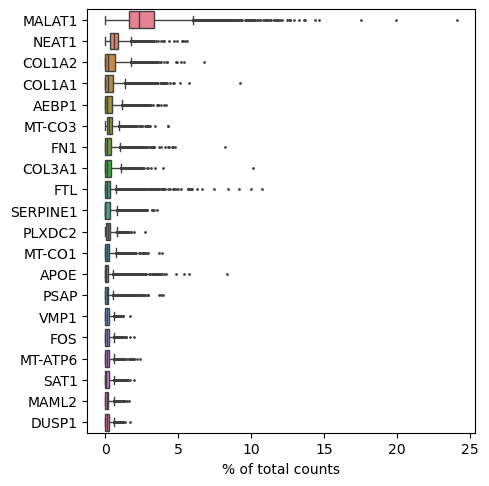

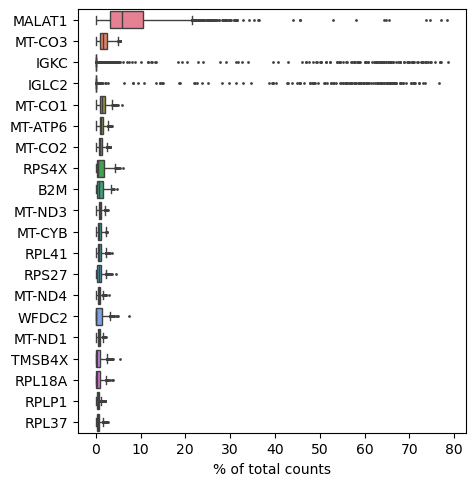

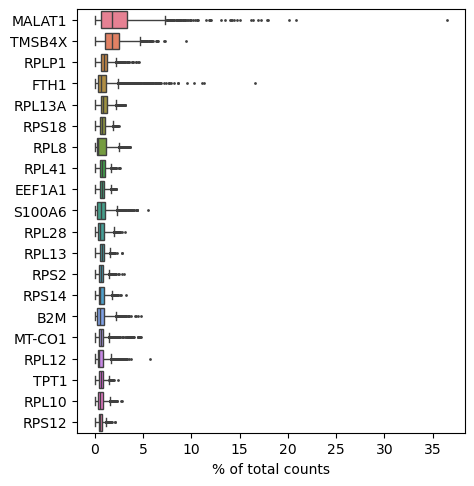

In [8]:
sc.pl.highest_expr_genes(
    sn_adata,
    n_top=20,
)
sc.pl.highest_expr_genes(
    sc_adata,
    n_top=20,
)
sc.pl.highest_expr_genes(
    sc_adata_test,
    n_top=20,
)

In [9]:
# QC, check it is not normalized
print(sn_adata.X.max())
print(sc_adata.X.max())
print(sc_adata_test.X.max())

766.0
8854.0
5508.0


We'll remove genes with high mitochondrial content

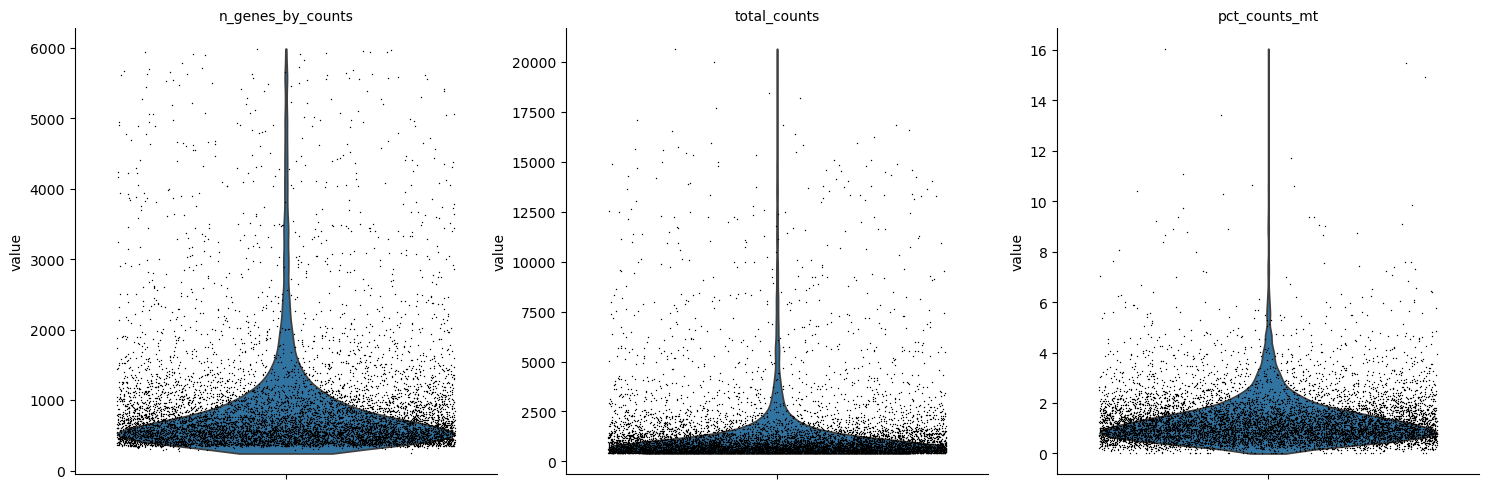

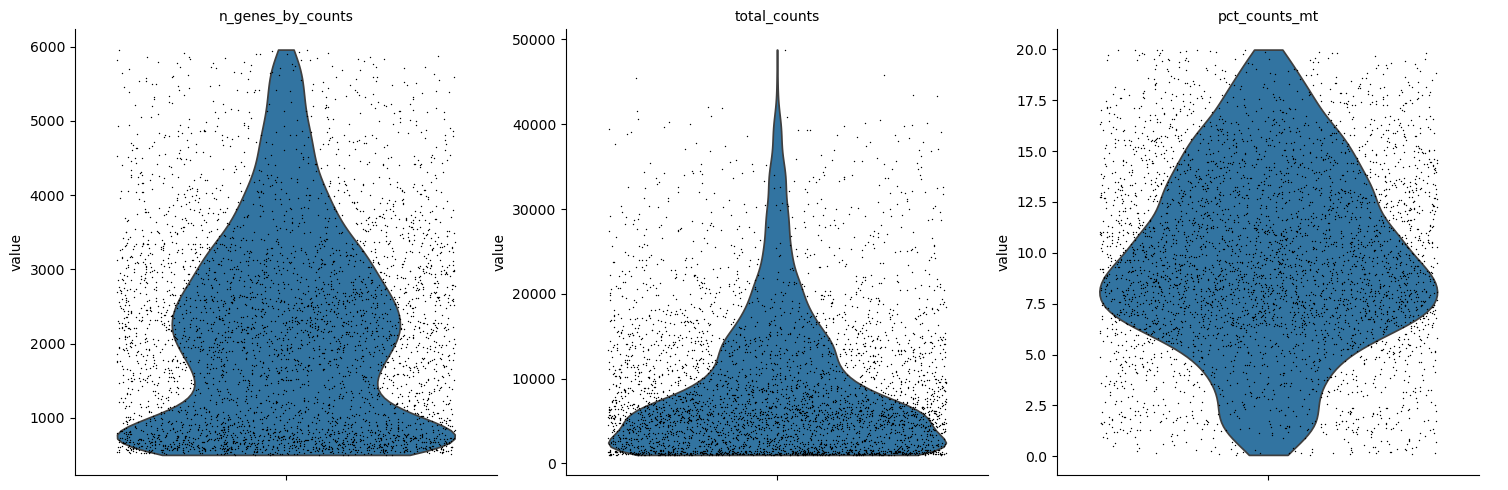

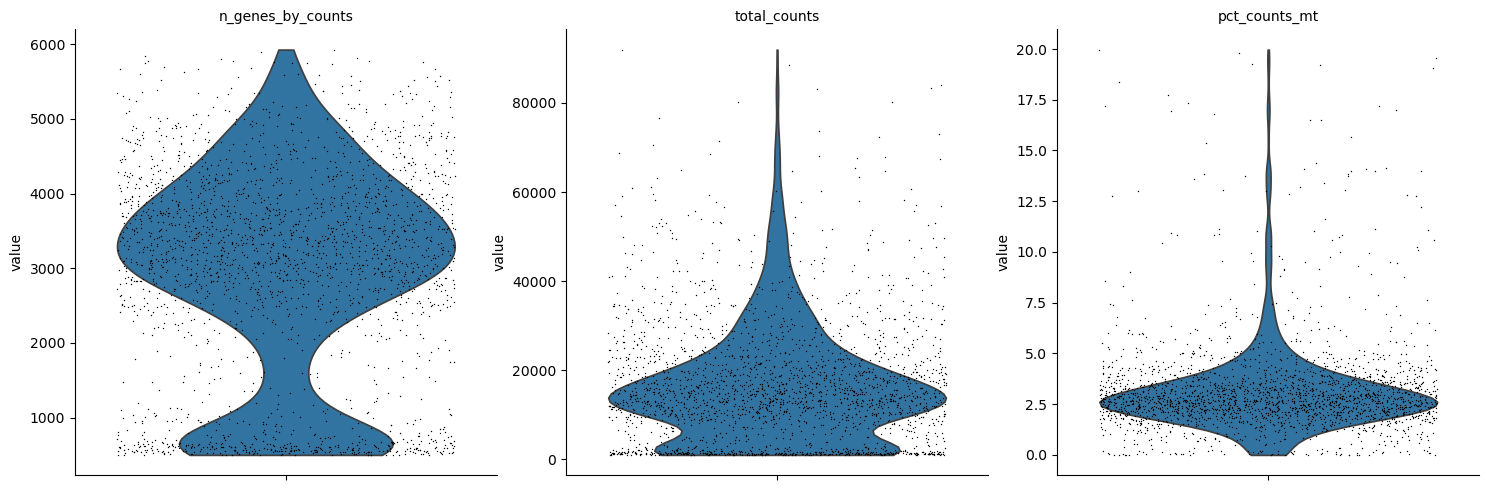

In [10]:
#  checking mitochondrial content, should not exceed 20%
sn_adata.var["mt"] = sn_adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sn_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sn_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# remove genes with high mitochondrial content
sc_adata.var["mt"] = sc_adata.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sc_adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sc_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

# remove genes with high mitochondrial content
sc_adata_test.var["mt"] = sc_adata_test.var_names.str.startswith(
    "MT-"
)  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(
    sc_adata_test, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    sc_adata_test,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

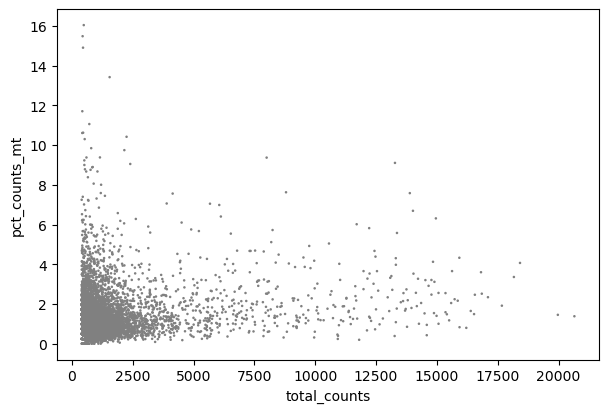

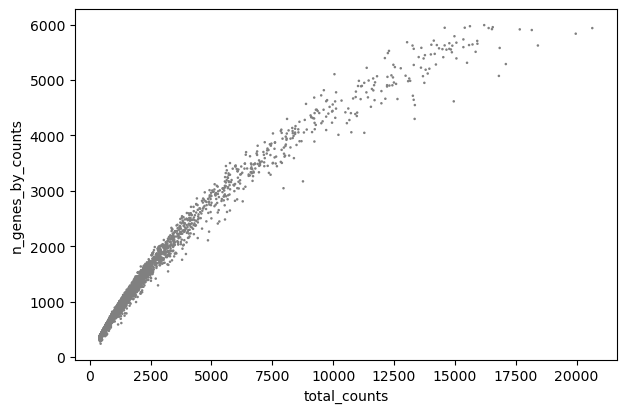

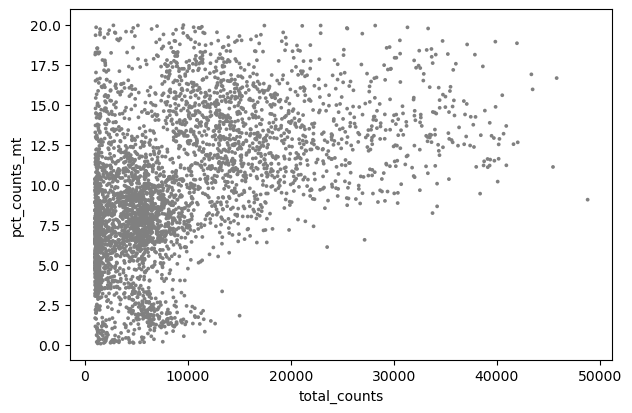

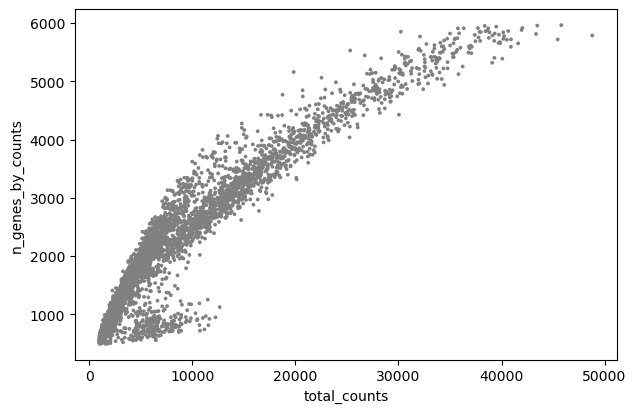

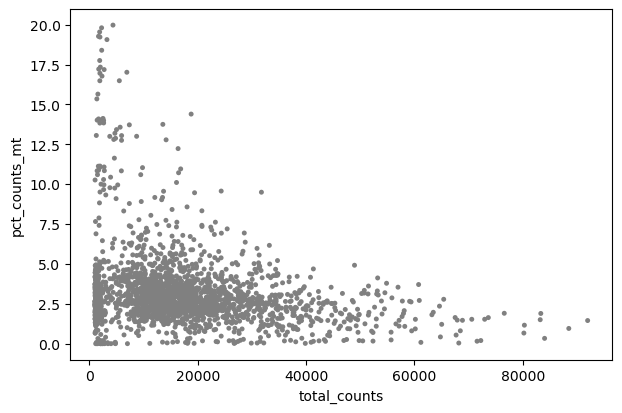

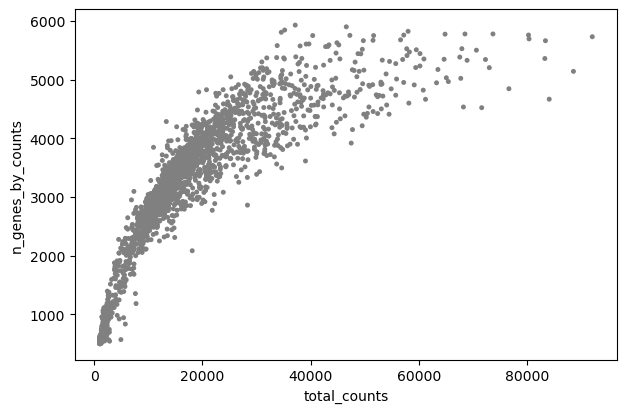

In [11]:
sc.pl.scatter(sn_adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sn_adata, x="total_counts", y="n_genes_by_counts")

sc.pl.scatter(sc_adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sc_adata, x="total_counts", y="n_genes_by_counts")

sc.pl.scatter(sc_adata_test, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(sc_adata_test, x="total_counts", y="n_genes_by_counts")

## **Assigning cell types:**

In [12]:
sn_adata = assign_cell_types(sn_adata, sn_metadata["annotate"].values)
sc_adata = assign_cell_types(sc_adata, sc_metadata["annotate"].values)
sc_adata_test = assign_cell_types(sc_adata_test, sc_metadata_test["annotate"].values)

Done!
Cell Types in Data are: cell_types
Macrophage                      3374
Fibroblast                      3346
Epithelial cell                 1254
Doublet/Fibrocyte/Osteoblast     625
T cell                           179
Endothelial cell                 127
B cell                            81
Mast cell                         40
Name: count, dtype: int64
Done!
Cell Types in Data are: cell_types
Epithelial cell          1498
Macrophage               1020
T cell                    630
B cell                    326
Empty/Epithelial cell     235
Endothelial cell          189
Fibroblast                133
NK cell                    35
Name: count, dtype: int64
Done!
Cell Types in Data are: cell_types
Fibroblast               1214
Epithelial cell           704
NK cell                   357
Empty/Epithelial cell      52
Macrophage                 32
Name: count, dtype: int64


In [13]:
# making copy to keep unnormalized for export
sn_adata_copy = sn_adata.copy()
sc_adata_copy = sc_adata.copy()
sc_adata_test_copy = sc_adata_test.copy()

# normalize to 10K counts per cell
sc.pp.normalize_total(sn_adata, target_sum=1e4)
# logging local adata
sc.pp.log1p(sn_adata)

sc.pp.normalize_total(sc_adata, target_sum=1e4)
# logging local adata
sc.pp.log1p(sc_adata)

sc.pp.normalize_total(sc_adata_test, target_sum=1e4)
# logging local adata
sc.pp.log1p(sc_adata_test)

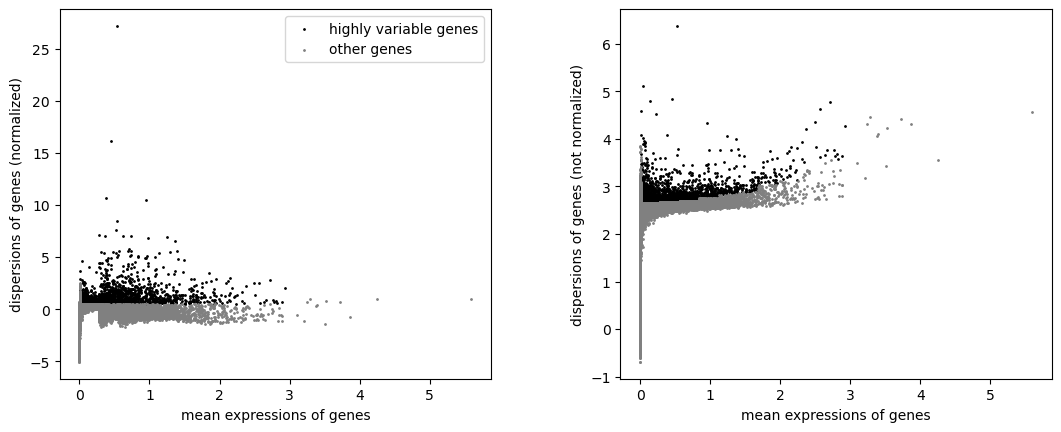

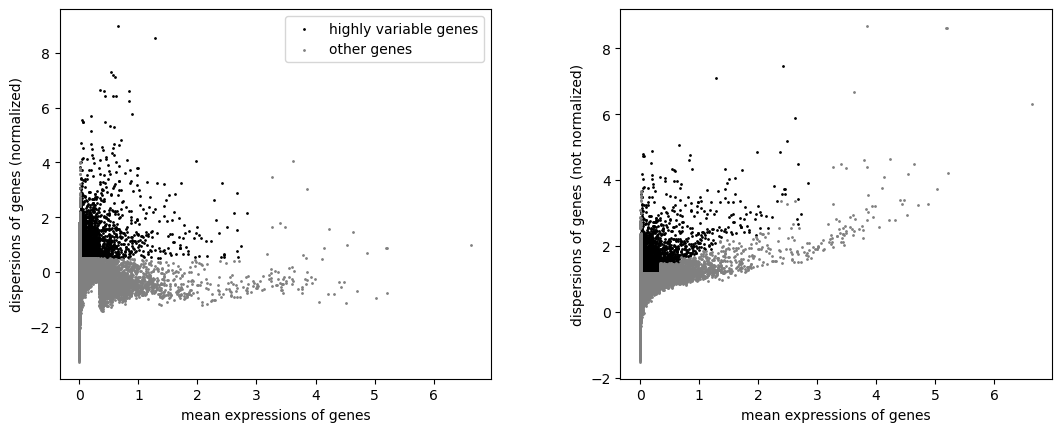

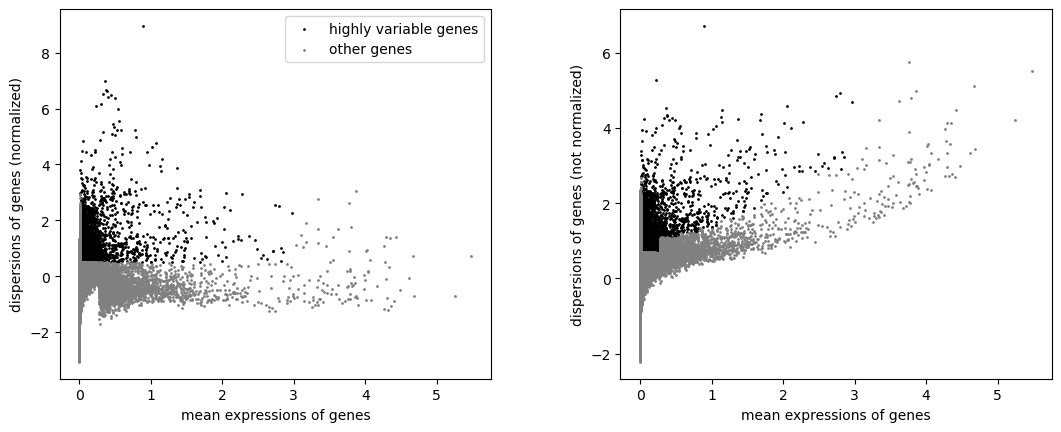

In [14]:
highly_var_genes = sc.pp.highly_variable_genes(
    sn_adata, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sn_adata)

highly_var_genes = sc.pp.highly_variable_genes(
    sc_adata, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sc_adata)

highly_var_genes = sc.pp.highly_variable_genes(
    sc_adata_test, min_mean=0.0125, max_mean=3, min_disp=0.5
)
sc.pl.highly_variable_genes(sc_adata_test)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33694 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


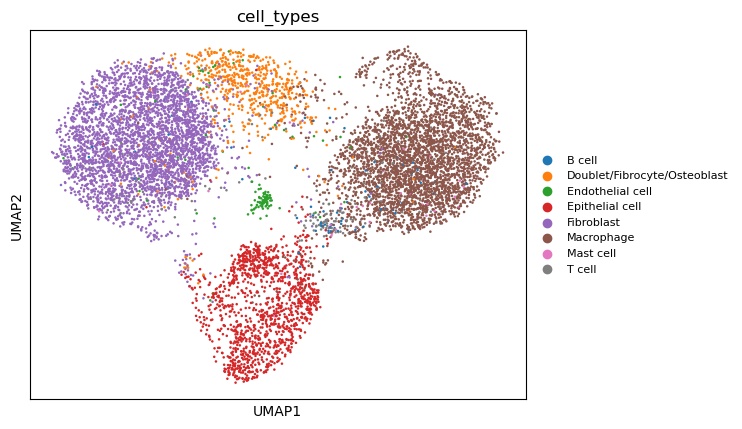

In [15]:
# calculate neighborhood graph
sc.pp.neighbors(sn_adata)

# make umap
sc.tl.umap(sn_adata)

# plot some markers of the RAW data
sc.pl.umap(sn_adata, color="cell_types", legend_fontsize=8)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33538 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


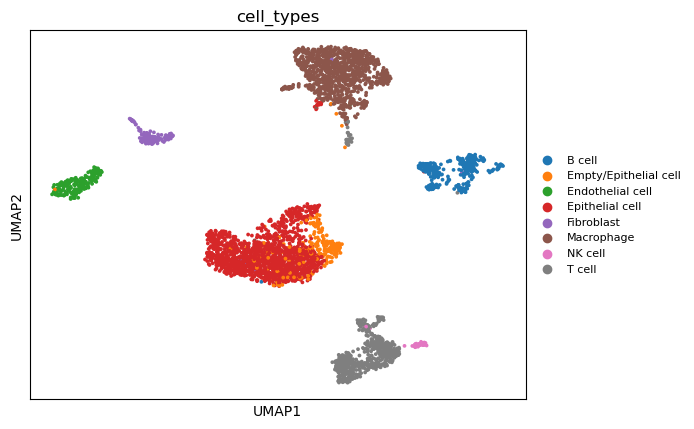

In [16]:
# calculate neighborhood graph
sc.pp.neighbors(sc_adata)

# make umap
sc.tl.umap(sc_adata)

# plot some markers of the RAW data
sc.pl.umap(sc_adata, color="cell_types", legend_fontsize=8)

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 33694 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


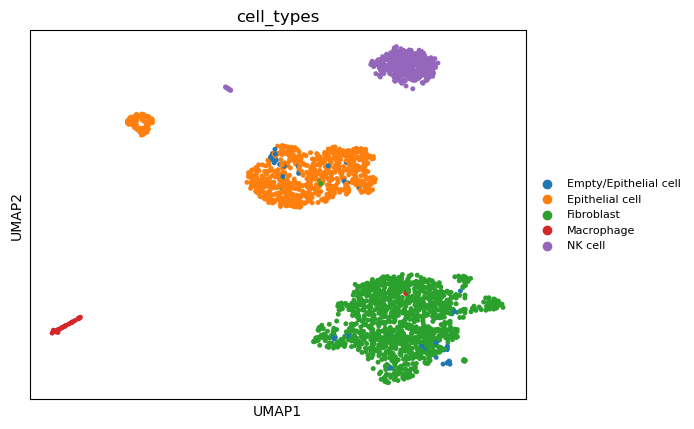

In [17]:
# calculate neighborhood graph
sc.pp.neighbors(sc_adata_test)

# make umap
sc.tl.umap(sc_adata_test)

# plot some markers of the RAW data
sc.pl.umap(sc_adata_test, color="cell_types", legend_fontsize=8)

## Cell type assignment QC:

In [18]:
# and repeat for unnormalized data
sn_adata_copy.obs["cell_types"] = sn_adata.obs["cell_types"]
sc_adata_copy.obs["cell_types"] = sc_adata.obs["cell_types"]
sc_adata_test_copy.obs["cell_types"] = sc_adata_test.obs["cell_types"]

In [19]:
sn_prop = make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
5,B cell,81,0.008974
4,Doublet/Fibrocyte/Osteoblast,625,0.069244
7,Endothelial cell,127,0.014070
2,Epithelial cell,1254,0.138932
1,Fibroblast,3346,0.370707
0,Macrophage,3374,0.373809
6,Mast cell,40,0.004432
3,T cell,179,0.019832


In [20]:
sc_prop = make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
5,B cell,326,0.080177
1,Empty/Epithelial cell,235,0.057796
4,Endothelial cell,189,0.046483
0,Epithelial cell,1498,0.368421
6,Fibroblast,133,0.032710
3,Macrophage,1020,0.250861
7,NK cell,35,0.008608
2,T cell,630,0.154943


In [21]:
sc_prop_test = make_prop_table(sc_adata_test, "cell_types")
sc_prop_test = sc_prop_test[:-1]
sc_prop_test.sort_values("Cell_Types")

,Cell_Types,Num_Cells,Prop_Cells
3,Empty/Epithelial cell,52,0.022043
2,Epithelial cell,704,0.298432
0,Fibroblast,1214,0.514625
4,Macrophage,32,0.013565
1,NK cell,357,0.151335


## Now matching cell types in both

In [22]:
sn_adata, sc_adata = match_cell_types(
    sn_adata_copy,
    sc_adata_copy,
    np.intersect1d(sn_adata.obs.cell_types.unique(), sc_adata.obs.cell_types.unique()),
)

In [23]:
sc_adata_test, sc_adata = match_cell_types(
    sc_adata_test_copy,
    sc_adata_copy,
    np.intersect1d(
        sc_adata_test.obs.cell_types.unique(), sc_adata.obs.cell_types.unique()
    ),
)

In [24]:
# QC:
print("Cells in single-nucleus:")
print(sn_adata.obs.cell_types.unique())
print("Cells in single-cell:")
print(sc_adata.obs.cell_types.unique())
print("Cells in single-cell testing set:")
print(sc_adata_test.obs.cell_types.unique())

Cells in single-nucleus:
['Macrophage', 'Fibroblast', 'Epithelial cell', 'T cell', 'B cell', 'Endothelial cell']
Categories (6, object): ['B cell', 'Endothelial cell', 'Epithelial cell', 'Fibroblast', 'Macrophage', 'T cell']
Cells in single-cell:
['Epithelial cell', 'Macrophage', 'Fibroblast']
Categories (3, object): ['Epithelial cell', 'Fibroblast', 'Macrophage']
Cells in single-cell testing set:
['Fibroblast', 'Epithelial cell', 'Macrophage']
Categories (3, object): ['Epithelial cell', 'Fibroblast', 'Macrophage']


## Saving both

In [25]:
# These should not be normalized
print(sn_adata.X.max())
print(sc_adata.X.max())
print(sc_adata_test.X.max())

766.0
8854.0
5508.0


## Finally matching genes

In [26]:
genes_to_keep = sorted(set(sn_adata.var_names.values)&set(sc_adata.var_names.values)&set(sc_adata_test.var_names.values))
genes_to_keep

['A1BG',
 'A1BG-AS1',
 'A1CF',
 'A2M',
 'A2M-AS1',
 'A2ML1',
 'A2ML1-AS1',
 'A2ML1-AS2',
 'A3GALT2',
 'A4GALT',
 'A4GNT',
 'AAAS',
 'AACS',
 'AADAC',
 'AADACL2',
 'AADACL2-AS1',
 'AADACL3',
 'AADACL4',
 'AADAT',
 'AAED1',
 'AAGAB',
 'AAK1',
 'AAMDC',
 'AAMP',
 'AANAT',
 'AAR2',
 'AARD',
 'AARS',
 'AARS2',
 'AARSD1',
 'AASDH',
 'AASDHPPT',
 'AASS',
 'AATBC',
 'AATF',
 'AATK',
 'ABALON',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA12',
 'ABCA13',
 'ABCA2',
 'ABCA3',
 'ABCA4',
 'ABCA5',
 'ABCA6',
 'ABCA7',
 'ABCA8',
 'ABCA9',
 'ABCA9-AS1',
 'ABCB1',
 'ABCB10',
 'ABCB11',
 'ABCB4',
 'ABCB5',
 'ABCB6',
 'ABCB7',
 'ABCB8',
 'ABCB9',
 'ABCC1',
 'ABCC10',
 'ABCC11',
 'ABCC12',
 'ABCC2',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC5-AS1',
 'ABCC6',
 'ABCC8',
 'ABCC9',
 'ABCD1',
 'ABCD2',
 'ABCD3',
 'ABCD4',
 'ABCE1',
 'ABCF1',
 'ABCF2',
 'ABCF3',
 'ABCG1',
 'ABCG2',
 'ABCG4',
 'ABCG5',
 'ABCG8',
 'ABHD1',
 'ABHD10',
 'ABHD11',
 'ABHD12',
 'ABHD12B',
 'ABHD13',
 'ABHD14A',
 'ABHD14A-ACY1',
 'ABHD14B',
 'ABHD15'

In [27]:
sn_adata = sn_adata[:, genes_to_keep]
sc_adata = sc_adata[:, genes_to_keep]
sc_adata_test = sc_adata_test[:, genes_to_keep]

In [28]:
sc_adata_test.obs["deconvolution"] = "pseudobulks"
sc_adata.obs["deconvolution"] = "reference"
sn_adata.obs["deconvolution"] = "reference"

/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/770530534.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata_test.obs["deconvolution"] = "pseudobulks"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/770530534.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sc_adata.obs["deconvolution"] = "reference"
/projects/aivich@xsede.org/code-server/tmp/ipykernel_612547/770530534.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  sn_adata.obs["deconvolution"] = "reference"


QC:

In [29]:
print(sn_adata)
print(sc_adata)
print(sc_adata_test)

AnnData object with n_obs × n_vars = 8361 × 22164
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 2651 × 22164
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1950 × 22164
    obs: 'data_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types', 'deconvolution'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [30]:
maps = {
    "dendritic cell": "Dendritic Cells",
    "endothelial cell": "Endothelial Cells",
    "immature NK T cell": "Immature NK T Cells",
    "monocyte": "Monocytes",
    "preadipocyte": "Preadipocytes",
    "T cell": "T Cells",
    "Endothelial cell": "Endothelial Cells",
    "T cell": "T Cells",
    "Macrophage": "Macrophages",
    "macrophage": "Macrophages",
    "Hepatocyte": "Hepatocytes",
    "Epithelial cell": "Epithelial Cells",
}
sn_adata.obs.cell_types = sn_adata.obs.cell_types.replace(maps)
sc_adata.obs.cell_types = sc_adata.obs.cell_types.replace(maps)
sc_adata_test.obs.cell_types = sc_adata_test.obs.cell_types.replace(maps)

In [31]:
print(sn_adata.obs.cell_types.value_counts())
print(sc_adata.obs.cell_types.value_counts())
print(sc_adata_test.obs.cell_types.value_counts())

cell_types
Macrophages          3374
Fibroblast           3346
Epithelial Cells     1254
T Cells               179
Endothelial Cells     127
B cell                 81
Name: count, dtype: int64
cell_types
Epithelial Cells    1498
Macrophages         1020
Fibroblast           133
Name: count, dtype: int64
cell_types
Fibroblast          1214
Epithelial Cells     704
Macrophages           32
Name: count, dtype: int64


In [32]:
all_adatas = sc.concat([sn_adata, sc_adata_test, sc_adata])

/projects/aivich@xsede.org/.conda/envs/env_deconv/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
path = f"{os.getcwd()}/../data/{res_name}/"
# saving for later adata as anndata without normalization
adata_path = os.path.join(path, f"sc_sn_{res_name}_processed.h5ad")
adata_path = Path(adata_path)
all_adatas.write_h5ad(adata_path)